In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from matplotlib import pyplot as plt
%matplotlib inline 
xp = cuda.cupy
import time


def model_func(model):
    if xp == np:
        pass
    else :
        gpu_device = 0
        cuda.get_device(gpu_device).use()
        model.to_gpu(gpu_device)
xp.model_init = model_func
xp.pi = np.pi

In [22]:
from chainer.utils import type_check
class ELU(Function):

    """Exponential Linear Unit."""
    # https://github.com/muupan/chainer-elu

    def __init__(self, alpha=1.0):
        self.alpha = xp.float32(alpha)

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 1)
        x_type, = in_types

        type_check.expect(
            x_type.dtype == xp.float32,
        )

    def forward_cpu(self, x):
        y = x[0].copy()
        neg_indices = x[0] < 0
        y[neg_indices] = self.alpha * (xp.exp(y[neg_indices]) - 1)
        return y,

    def forward_gpu(self, x):
        y = cuda.elementwise(
            'T x, T alpha', 'T y',
            'y = x >= 0 ? x : alpha * (exp(x) - 1)', 'elu_fwd')(
                x[0], self.alpha)
        return y,

    def backward_cpu(self, x, gy):
        gx = gy[0].copy()
        neg_indices = x[0] < 0
        gx[neg_indices] *= self.alpha * xp.exp(x[0][neg_indices])
        return gx,

    def backward_gpu(self, x, gy):
        gx = cuda.elementwise(
            'T x, T gy, T alpha', 'T gx',
            'gx = x >= 0 ? gy : gy * alpha * exp(x)', 'elu_bwd')(
                x[0], gy[0], self.alpha)
        return gx,


def elu(x, alpha=1.0):
    """Exponential Linear Unit function."""
    # https://github.com/muupan/chainer-elu
    return ELU(alpha=alpha)(x)


In [3]:
def mk_seq_dat(N=10000,M = 1024):
    dt = 0.1
    t = xp.linspace(0,dt*M,M).reshape(1,M)
    w = xp.random.rand(N).reshape(N,1) * 2 + 1
    p = xp.random.rand(N).reshape(N,1) * np.pi * 2
    r = xp.random.rand(N).reshape(N,1) * 0.5 + 0.5
    x = xp.sin(w * t + p ) * r
    
    w2= xp.random.rand(N).reshape(N,1) * 2 + 1
    p2= xp.random.rand(N).reshape(N,1) * np.pi * 2
    r2= xp.random.rand(N).reshape(N,1) * 0.5 + 0.5
    x+= xp.sin(w2* t + p2) * r2
    
    x = x.reshape(N,1,M).astype(np.float32)
    return x
dat = mk_seq_dat()

In [4]:
def getMini(dat,mN = 50):
    r = np.random.randint(dat.shape[0]//mN)
    return dat[r*mN:(r+1)*mN]

/nfs/home/endo/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/chainer/cuda.py:92: UserWarning: cuDNN is not enabled.
Please reinstall chainer after you install cudnn
(see https://github.com/pfnet/chainer#installation).
  'cuDNN is not enabled.\n'


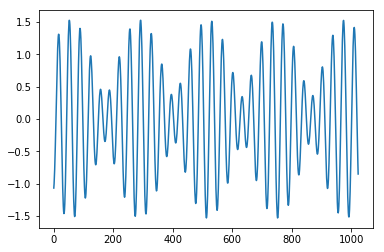

In [5]:
l = 1
r = np.random.randint(100)
smp = cuda.to_cpu(dat[r:r+l])
plt.plot(smp.reshape(l,-1).T)
plt.show()
#ff = np.abs(np.fft.fft(smp))
#plt.plot(ff[:200])
#plt.show()

In [6]:

    
def add1(v):
    return v+1

def mul2(v):
    return v*2

a = Path(1)(add1)(add1)(mul2)(add1)(mul2)(add1)()
print (a)

15


In [9]:
def prt_shape(v):
    print (v.shape)
    return v

def RES(*p):
    def _(v):
        N = v.shape[0]
        tup = (N,) + p
        #print (v.shape)
        return F.reshape(v,tup)
    return _

def Add(v1):
    def _(v2):
        return v1 + v2
    return _

class PRD(Chain):
    def __init__(this):
        super().__init__(
            p1 = L.ConvolutionND(1,1,8,2,stride=2,pad=0),
            p2 = L.ConvolutionND(1,8,16,2,stride=2,pad=0),
            p3 = L.ConvolutionND(1,16,32,2,stride=2,pad=0),
            p4 = L.ConvolutionND(1,32,64,2,stride=2,pad=0),
            p5 = L.ConvolutionND(1,64,128,2,stride=2,pad=0),
            p6 = L.ConvolutionND(1,128,256,2,stride=2,pad=0),
            p7 = L.ConvolutionND(1,256,512,2,stride=2,pad=0),
            l1 = L.Linear(512*4,1024),
            l2 = L.Linear(1024,512*4),
            q7 = L.DeconvolutionND(1,512,256,2,stride=2,pad=0),
            q6 = L.DeconvolutionND(1,256,128,2,stride=2,pad=0),
            q5 = L.DeconvolutionND(1,128,64,2,stride=2,pad=0),
            q4 = L.DeconvolutionND(1,64,32,2,stride=2,pad=0),
            q3 = L.DeconvolutionND(1,32,16,2,stride=2,pad=0),
            q2 = L.DeconvolutionND(1,16,8,2,stride=2,pad=0),
            q1 = L.DeconvolutionND(1,8,1,2,stride=2,pad=0),
        )
    def __call__(this,x):
        h = Path(x)(this.p1)(elu)(this.p2)(elu)(this.p3)(elu)(this.p4)(elu)(this.p5)(elu)(this.p6)(elu)(this.p7)(elu)()
        h = Path(h)(RES(512*4))()
        h = Path(h)(this.l1)(elu)(this.l2)(Add(h))(elu)(RES(512,4))()
        h = Path(h)(this.q7)(elu)(this.q6)(elu)(this.q5)(elu)(this.q4)(elu)(this.q3)(elu)(this.q2)(elu)(this.q1)()
        return h
    
prd = PRD()
xp.model_init(prd)

opt = optimizers.Adam()
opt.setup(prd)
opt.add_hook(chainer.optimizer.WeightDecay(0.0001))
c = 0

In [18]:
stp = 10000
prt = 100

for i in range(stp):
    c +=1
    
    d = getMini(dat,50)
    x,t = np.split(d,2,axis = 2)
    
    
    y = prd(x)
    loss = F.mean_squared_error(y,t)
    
    prd.cleargrads()
    loss.backward()
    opt.update()
    
    if c % prt == 0:
        print (c,loss.data)

20700 0.047563571482896805
20800 0.04426952451467514
20900 0.05192181095480919
21000 0.0406775139272213
21100 0.04213803634047508
21200 0.05555105209350586
21300 0.03961113467812538
21400 0.03089148737490177
21500 0.05233455076813698
21600 0.04187934845685959
21700 0.05691070482134819
21800 0.03909260779619217
21900 0.04028980806469917
22000 0.03455705568194389
22100 0.04205158352851868
22200 0.04918600618839264
22300 0.04287676885724068
22400 0.05304349958896637
22500 0.057726506143808365
22600 0.023354392498731613
22700 0.04020512476563454
22800 0.05539350584149361
22900 0.05003299564123154
23000 0.0599457323551178
23100 0.03678959235548973
23200 0.03940577059984207
23300 0.05088598281145096
23400 0.04479699209332466
23500 0.03362082690000534
23600 0.0449608750641346
23700 0.04026470333337784
23800 0.033735986799001694
23900 0.06181338429450989
24000 0.019066154956817627
24100 0.029146084561944008
24200 0.060459353029727936
24300 0.03289780020713806
24400 0.03267234191298485
24500 0.

(512,)


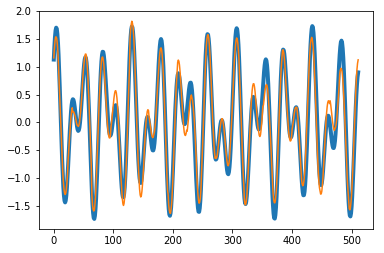

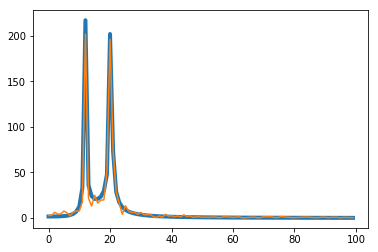

In [24]:
r = np.random.randint(100)
d = dat[r:r+1] * -1
x,t = np.split(d,2,axis=2)
y = prd(x)

_t = cuda.to_cpu(t).reshape(-1)
_y = cuda.to_cpu(y.data).reshape(-1)
print (_y.shape)
plt.plot(_t,linewidth=4)
plt.plot(_y,)
plt.show()
fft = np.abs(np.fft.fft(_t))
ffy = np.abs(np.fft.fft(_y))
plt.plot(fft[:100],linewidth=4)
plt.plot(ffy[:100])
plt.show()